In [1]:
from src.visualise import settings
from src.visualise.plot import plot_data
from src.data.paths import project_dir
from src.data.analysis import read_tiff_img, Circle, create_circular_mask
from src.data.detector import find_circle_hough_method, img_for_circle_detection

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import re

from dataclasses import dataclass, field
from pathlib import Path

from copy import deepcopy

import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

# Efficiency data

In [2]:
df = pd.read_hdf(project_dir / 'data' / 'interim' / 'data.h5', key='df')
df

,det_no,mean_signal,std_signal,radiation,circle_no
18000,1,81.091195,25.427066,Co60,0
18001,1,82.529968,26.405774,Co60,1
18002,1,83.920886,27.023140,Co60,2
18003,1,82.619048,26.932148,Co60,3
18004,1,82.932692,25.610719,Co60,4
...,...,...,...,...,...
17995,18,29.259615,21.293731,proton,995
17996,18,11.805031,13.035982,proton,996
17997,18,17.227564,15.749933,proton,997
17998,18,16.050633,14.261925,proton,998


In [3]:
df2 = pd.DataFrame()
df2["mean"] = df.groupby(["radiation", "det_no"])["mean_signal"].mean()
df2["std"] = df.groupby(["radiation", "det_no"])["mean_signal"].std()
df2

mean        std
radiation det_no                       
Co60      1        83.824452   1.903466
          2        84.249438   1.478100
          3        85.107729   2.399810
          4        86.491055   2.201645
          5        84.977943   2.376708
          6        81.383114   2.307891
          7        82.567876   2.677266
          8        76.305738   9.391403
          9        85.223569   1.590584
          10       78.830512   1.811209
          11       79.389846   2.042538
          12       79.451727   1.595187
          13       81.030344   2.593637
          14       80.287139   2.348115
          15       77.160063   2.301591
          16       81.301845   2.886143
          17       81.147445   1.971329
          18        5.433894   0.393033
proton    1        75.390267   2.340467
          2        74.558735   2.085833
          3        77.405837   3.977132
          4        83.314926   3.924848
          5        69.357364   8.995399
          6        95.808612   6.717133
          7       100.180247   7.459077
          8       109.690233  10.687577
          9       119.496300  15.656712
          10      120.289781  14.449843
          11      124.974972  11.241082
          12      134.722452  15.089489
          13      142.431324  15.657994
          14      151.909514  16.621156
          15      151.560248  20.247061
          16      157.613037  26.547269
          17      178.059828  23.630994
          18       18.514460  15.182875

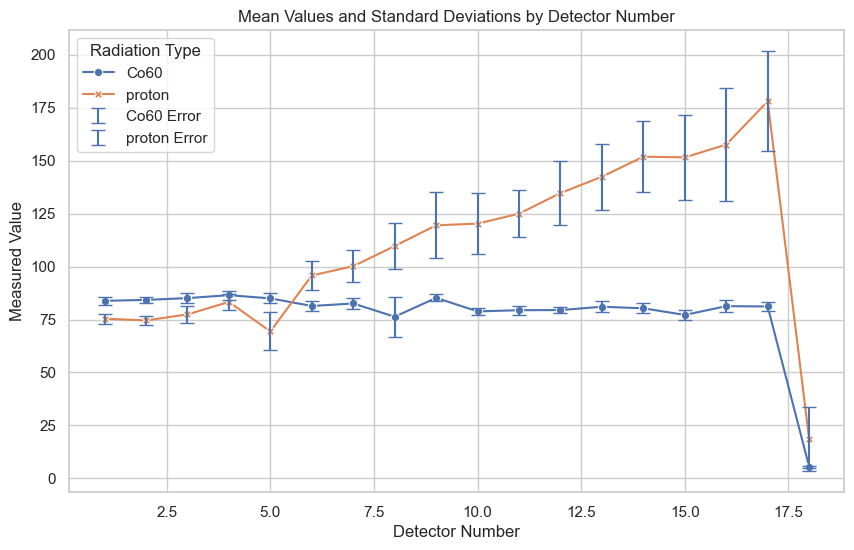

In [4]:
# Reset the index if df2 is a MultiIndex DataFrame
df2_reset = df2.reset_index()

# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Plot the mean values with line and scatter points
sns.lineplot(data=df2_reset, x='det_no', y='mean', hue='radiation', style='radiation', markers=True, dashes=False)

# Add error bars
for radiation_type in df2_reset['radiation'].unique():
    subset = df2_reset[df2_reset['radiation'] == radiation_type]
    plt.errorbar(subset['det_no'], subset['mean'], yerr=subset['std'], fmt='none', capsize=5, label=f'{radiation_type} Error')

plt.title('Mean Values and Standard Deviations by Detector Number')
plt.xlabel('Detector Number')
plt.ylabel('Measured Value')
plt.legend(title='Radiation Type')

# Bragg peak data from dosimetry and MC

In [30]:
plots_path = Path('C:\\Users\\Legion\\OneDrive - ifj.edu.pl\\Projects\\MB_foils\\2024-04-22\\article-plots.h5')
#plots_path = project_dir / 'data' / 'raw' / 'article-plots.h5'
df_bp_exp = pd.read_hdf(plots_path, key='bp_exp')
df_bp_mc = pd.read_hdf(plots_path, key='bp_mc')

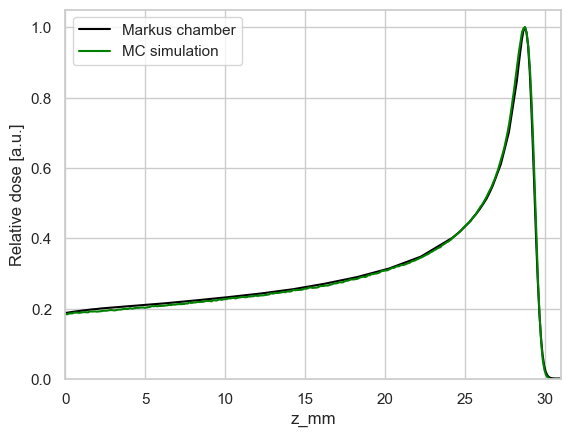

In [31]:
fig, ax_up = plt.subplots(nrows=1, sharex=True)
df_bp_exp.plot(ax=ax_up, x='Depth', y='Signal', label='Markus chamber', color='black', style='-')
df_bp_mc.plot(ax=ax_up, x='z_mm', y='dose', label='MC simulation', color='green', style='-')
ax_up.set_ylim(0,1.05)
ax_up.set_xlim(0, 31)
ax_up.set_ylabel("Relative dose [a.u.]");

# Detector positions

In [32]:
# xls_path = project_dir / 'data' / 'raw' / 'foils_phantom.xlsx'
xls_path = Path('C:\\Users\\Legion\\OneDrive - ifj.edu.pl\\Projects\\MB_foils\\2024-04-22\\fantom.xlsx')
df_pos = pd.read_excel(xls_path, 
sheet_name='PB_MBO', 
skiprows=5, 
nrows=36, 
usecols="A,C:E",
names=["det_no", "name", "det_thick", "WER"])
# add new column det_start which is sum of WER for all indexes lower than current
df_pos['det_end'] = df_pos.WER.cumsum()
df_pos['det_begin'] = df_pos.det_end - df_pos.WER
df_pos = df_pos[df_pos.name == 'folia MBO']
df_pos.drop("name", axis=1, inplace=True)
df_pos['det_mid'] = (df_pos.det_begin + df_pos.det_end) / 2
df_pos

,det_no,det_thick,WER,det_end,det_begin,det_mid
1,1.0,0.42,0.4410,0.8078,0.3668,0.58730
4,2.0,0.41,0.4305,3.7939,3.3634,3.57865
7,3.0,0.43,0.4515,6.8010,6.3495,6.57525
10,4.0,0.44,0.4620,9.8072,9.3452,9.57620
13,5.0,0.44,0.4620,12.8134,12.3514,12.58240
16,6.0,0.42,0.4410,15.7872,15.3462,15.56670
19,7.0,0.44,0.4620,18.7592,18.2972,18.52820
22,8.0,0.43,0.4515,21.7549,21.3034,21.52915
25,9.0,0.41,0.4305,24.7182,24.2877,24.50295
26,10.0,0.43,0.4515,25.1697,24.7182,24.94395


In [33]:
# join df_reset with df_pos on det_no
df_reset_pos = df2_reset.join(df_pos.set_index('det_no'), on='det_no')
df_reset_pos

,radiation,det_no,mean,std,det_thick,WER,det_end,det_begin,det_mid
0,Co60,1,83.824452,1.903466,0.42,0.4410,0.8078,0.3668,0.58730
1,Co60,2,84.249438,1.478100,0.41,0.4305,3.7939,3.3634,3.57865
2,Co60,3,85.107729,2.399810,0.43,0.4515,6.8010,6.3495,6.57525
3,Co60,4,86.491055,2.201645,0.44,0.4620,9.8072,9.3452,9.57620
4,Co60,5,84.977943,2.376708,0.44,0.4620,12.8134,12.3514,12.58240
5,Co60,6,81.383114,2.307891,0.42,0.4410,15.7872,15.3462,15.56670
6,Co60,7,82.567876,2.677266,0.44,0.4620,18.7592,18.2972,18.52820
7,Co60,8,76.305738,9.391403,0.43,0.4515,21.7549,21.3034,21.52915
8,Co60,9,85.223569,1.590584,0.41,0.4305,24.7182,24.2877,24.50295
9,Co60,10,78.830512,1.811209,0.43,0.4515,25.1697,24.7182,24.94395


(0.0, 30.0)

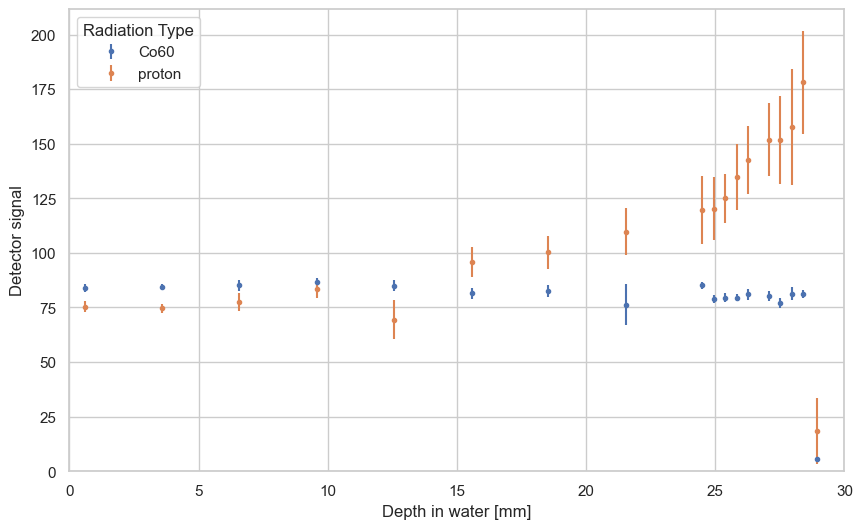

In [34]:
# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Add error bars
for radiation_type in df_reset_pos['radiation'].unique():
    subset = df_reset_pos[df_reset_pos['radiation'] == radiation_type]
    plt.errorbar(subset['det_mid'], subset['mean'], yerr=subset['std'], ls='', marker='.', label=f'{radiation_type}')

plt.xlabel('Depth in water [mm]')
plt.ylabel('Detector signal')
plt.legend(title='Radiation Type')
plt.ylim(0,None)
plt.xlim(0,30)

# Dose per detector

In [35]:
df_bp_mc

,zlower_cm,zupper_cm,dose,r.err,z_mm,dose_Gy
26,0.00,0.01,0.184743,0.0033,0.05,20.000000
27,0.01,0.02,0.184782,0.0034,0.15,20.004237
28,0.02,0.03,0.187052,0.0049,0.25,20.249965
29,0.03,0.04,0.186947,0.0041,0.35,20.238667
30,0.04,0.05,0.187195,0.0049,0.45,20.265499
...,...,...,...,...,...,...
421,3.95,3.96,0.000006,0.4542,39.55,0.000676
422,3.96,3.97,0.000016,0.5727,39.65,0.001760
423,3.97,3.98,0.000025,0.7804,39.75,0.002744
424,3.98,3.99,0.000028,0.7334,39.85,0.003082


In [36]:
# create spline interpolator object from scipy for x = df_bp_mc.z_mm and y = df_bp_mc.dose
from scipy.interpolate import interp1d
f = interp1d(df_bp_mc.z_mm, df_bp_mc.dose, kind='cubic')

In [37]:
df_bp_mc.iloc[0].dose

0.1847426230791307

In [39]:
# for such rows of df_reset_pos where radiation is 'proton' calculate 'dose' as f(df_reset_pos.det_mid)
entrance_dose_protons_Gy = 4
dose_Co60 = 4
df_reset_pos.loc[df_reset_pos.radiation == 'proton', 'dose'] = f(df_reset_pos[df_reset_pos.radiation == 'proton'].det_mid) / df_bp_mc.iloc[0].dose * entrance_dose_protons_Gy
df_reset_pos.loc[df_reset_pos.radiation == 'Co60', 'dose'] = dose_Co60

In [40]:
df_reset_pos['mean_signal_per_Gy'] = df_reset_pos['mean'] / df_reset_pos['dose']
df_reset_pos['std_signal_per_Gy'] = df_reset_pos['std'] / df_reset_pos['dose']
df_reset_pos

,radiation,det_no,mean,std,det_thick,WER,det_end,det_begin,det_mid,dose,mean_signal_per_Gy,std_signal_per_Gy
0,Co60,1,83.824452,1.903466,0.42,0.4410,0.8078,0.3668,0.58730,4.000000,20.956113,0.475866
1,Co60,2,84.249438,1.478100,0.41,0.4305,3.7939,3.3634,3.57865,4.000000,21.062359,0.369525
2,Co60,3,85.107729,2.399810,0.43,0.4515,6.8010,6.3495,6.57525,4.000000,21.276932,0.599952
3,Co60,4,86.491055,2.201645,0.44,0.4620,9.8072,9.3452,9.57620,4.000000,21.622764,0.550411
4,Co60,5,84.977943,2.376708,0.44,0.4620,12.8134,12.3514,12.58240,4.000000,21.244486,0.594177
5,Co60,6,81.383114,2.307891,0.42,0.4410,15.7872,15.3462,15.56670,4.000000,20.345778,0.576973
6,Co60,7,82.567876,2.677266,0.44,0.4620,18.7592,18.2972,18.52820,4.000000,20.641969,0.669316
7,Co60,8,76.305738,9.391403,0.43,0.4515,21.7549,21.3034,21.52915,4.000000,19.076434,2.347851
8,Co60,9,85.223569,1.590584,0.41,0.4305,24.7182,24.2877,24.50295,4.000000,21.305892,0.397646
9,Co60,10,78.830512,1.811209,0.43,0.4515,25.1697,24.7182,24.94395,4.000000,19.707628,0.452802


(0.0, 30.0)

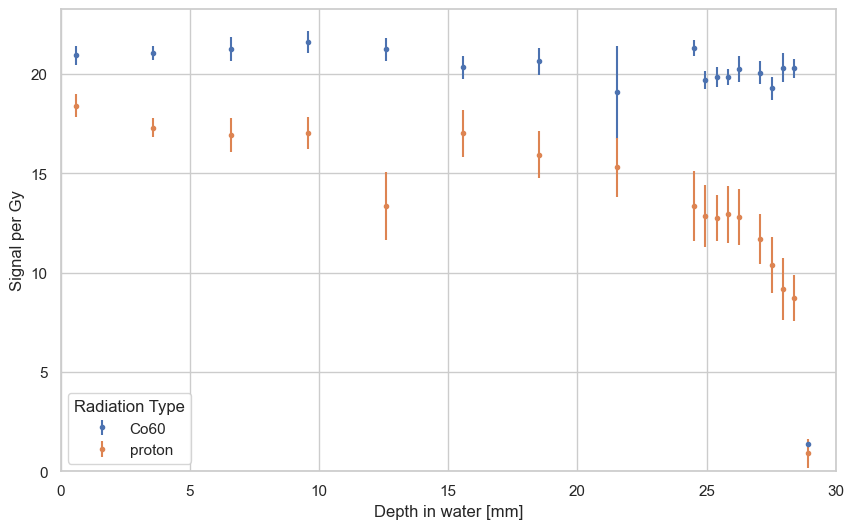

In [41]:
# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Add error bars
for radiation_type in df_reset_pos['radiation'].unique():
    subset = df_reset_pos[df_reset_pos['radiation'] == radiation_type]
    plt.errorbar(subset['det_mid'], subset['mean_signal_per_Gy'], yerr=subset['std_signal_per_Gy'], ls='', marker='.', label=f'{radiation_type}')

plt.xlabel('Depth in water [mm]')
plt.ylabel('Signal per Gy')
plt.legend(title='Radiation Type')
plt.ylim(0,None)
plt.xlim(0,30)

In [42]:
co60_data = df_reset_pos.loc[df_reset_pos.radiation == 'Co60']
proton_data = df_reset_pos.loc[df_reset_pos.radiation == 'proton']
all_data = co60_data.merge(proton_data, on='det_no', suffixes=['_Co60', '_proton'])
all_data['mean_efficiency'] = all_data['mean_signal_per_Gy_proton'] / all_data['mean_signal_per_Gy_Co60']
numerator_relative_std = all_data['std_signal_per_Gy_proton'] / all_data['mean_signal_per_Gy_Co60']
denominator_term = all_data['mean_signal_per_Gy_proton'] * all_data['std_signal_per_Gy_Co60'] / (all_data['mean_signal_per_Gy_Co60']**2)
all_data['std_efficiency'] = numerator_relative_std + denominator_term

(0.0, 30.0)

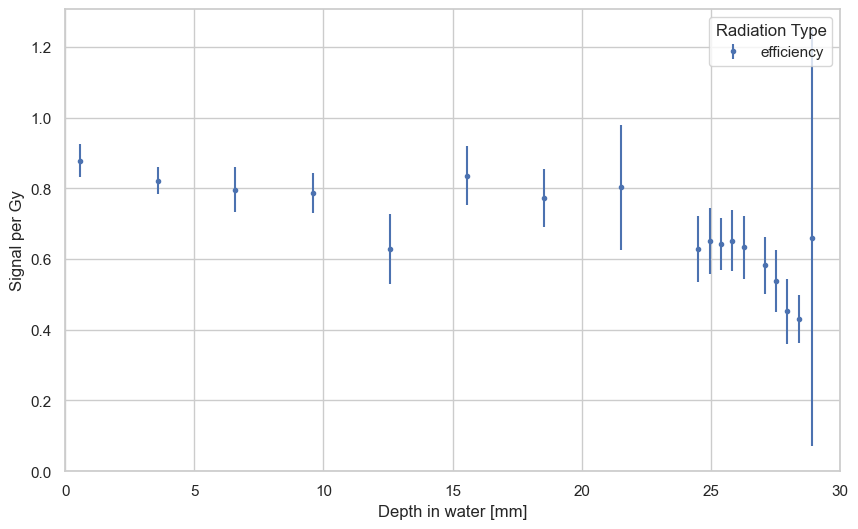

In [43]:
# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Add error bars
plt.errorbar(all_data['det_mid_proton'], all_data['mean_efficiency'], yerr=all_data['std_efficiency'], ls='', marker='.', label=f'efficiency')

plt.xlabel('Depth in water [mm]')
plt.ylabel('Signal per Gy')
plt.legend(title='Radiation Type')
plt.ylim(0,None)
plt.xlim(0,30)